# 1. Импортирование необходимых библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Загрузка и предварительный анализ данных

In [90]:
# Загрузка данных
train_df = pd.read_csv('train.csv')
lectures_df = pd.read_csv('lectures.csv')
questions_df = pd.read_csv('questions.csv')

In [91]:
# Предварительный осмотр данных
print(train_df.head())
print(lectures_df.head())
print(questions_df.head())

   row_id  timestamp  user_id  content_id  content_type_id  task_container_id   
0       0          0      115        5692                0                  1  \
1       1      56943      115        5716                0                  2   
2       2     118363      115         128                0                  0   
3       3     131167      115        7860                0                  3   
4       4     137965      115        7922                0                  4   

   user_answer  answered_correctly  prior_question_elapsed_time   
0            3                   1                          NaN  \
1            2                   1                     37000.00   
2            0                   1                     55000.00   
3            0                   1                     19000.00   
4            1                   1                     11000.00   

  prior_question_had_explanation  
0                            NaN  
1                          False  
2    

In [92]:
# Проверка пропусков в данных
print(train_df.isnull().sum())
print(lectures_df.isnull().sum())
print(questions_df.isnull().sum())

row_id                                  0
timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64
lecture_id    0
tag           0
part          0
type_of       0
dtype: int64
question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64


In [93]:
# Вывод первых строк каждой таблицы
print(train_df.info())
print(lectures_df.info())
print(questions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part   

# 3. Предобработка данных

In [94]:
# Заполнение средним значением
train_df['prior_question_elapsed_time'].fillna(train_df['prior_question_elapsed_time'].mean(), inplace=True)

In [95]:
# Заполнение значением False
train_df['prior_question_had_explanation'].fillna(False, inplace=True)

In [96]:
# Заполнение пропусков в 'tags' значением из предыдущей строки
questions_df['tags'].fillna(method='ffill', inplace=True)


# 4. Подготовка данных для анализа

In [97]:
# Выборка 30% от всех данных train_df, для более быстрой работы
truncated_train_df = train_df.sample(frac=0.3, random_state=1)

In [98]:
# Создаем датафрейм, в котором есть инфорамция только о вопросах
only_questions_df = truncated_train_df[truncated_train_df['content_type_id'] == 0].copy()

In [99]:
# Объединение данных для анализа вопросов
questions_merged_df = pd.merge(only_questions_df, questions_df, left_on='content_id', right_on='question_id')

In [100]:
# Объединение данных для анализа лекций
lectures_merged_df = pd.merge(truncated_train_df, lectures_df, left_on='content_id', right_on='lecture_id')

# 5. Анализ характеристик влияющих на успеваемость

In [101]:
#Анализ процента правильных ответов
correct_answers_rate = only_questions_df['answered_correctly'].mean()
print(f'Процент правильно отвеченных вопросов: {round(correct_answers_rate * 100,2)}%')

Процент правильно отвеченных вопросов: 65.73%


In [102]:
# Влияение наличия объяснений на процент правильных ответов
explanation_correct = only_questions_df.groupby('prior_question_had_explanation')['answered_correctly'].mean() * 100
print("Процент правильных ответов в зависимости от наличия объяснения:")
print(explanation_correct.round(2))

Процент правильных ответов в зависимости от наличия объяснения:
prior_question_had_explanation
False   50.78
True    67.33
Name: answered_correctly, dtype: float64


In [103]:
# Анализ правильных ответов по тегам
tag_correctness = questions_merged_df.groupby('tags')['answered_correctly'].mean()
print(tag_correctness)

tags
1                      0.61
1 162                  0.62
10 111 92              0.83
10 164 102             0.76
10 164 162 29          0.88
                       ... 
98 97 21               0.72
98 97 35 117 122 162   0.71
98 97 35 146 122       0.72
98 97 46 135           0.68
98 97 77 135 162       0.90
Name: answered_correctly, Length: 1519, dtype: float64


In [104]:
#Сводная таблица успеваемости по анализу доли вопросов с объяснением для каждой группы правильных и неправильных ответов
pivot_table1 = pd.pivot_table(
    only_questions_df,
    values='prior_question_had_explanation',
    index='answered_correctly',
    aggfunc=['mean']
)
display(pivot_table1)

,mean
,prior_question_had_explanation
answered_correctly,
0,0.86
1,0.93


In [107]:
# Сводная таблица успеваемости по разным группам вопросов
pivot_table2 = pd.pivot_table(
    questions_merged_df,
    values='answered_correctly',
    index='part',
    aggfunc=['mean']
)
display(pivot_table2)

,mean
,answered_correctly
part,
1,0.75
2,0.71
3,0.70
4,0.63
5,0.61
6,0.67
7,0.66


In [109]:
# Влияение посещения лекций на правильность ответа
# Создаем список уникальных пользователей, которые посещали лекции
users_attended_lecture = truncated_train_df[truncated_train_df['content_type_id'] == 1]['user_id'].unique()

# Добавляем новый столбец с флагом посещения лекции для уникальных пользователей
truncated_train_df['attended_lecture'] = truncated_train_df['user_id'].isin(users_attended_lecture)

# Подсчитываем количество уникальных пользователей, которые посещали и не посещали лекции
count_of_users_attended_lecture = truncated_train_df.drop_duplicates(subset='user_id')['attended_lecture'].value_counts()

print(count_of_users_attended_lecture)

attended_lecture
False    288875
True     104185
Name: count, dtype: int64


In [110]:
# Сводная таблица успеваемости студентов, которые присутствовали не лекциях
pivot_table3 = pd.pivot_table(
    truncated_train_df,
    values='answered_correctly',
    index='attended_lecture',
    aggfunc=['mean']
)
display(pivot_table3)

,mean
,answered_correctly
attended_lecture,
False,0.60
True,0.63


In [111]:
# Среднее время ответа для правильных и неправильных вариантов
avg_time_by_correctness = only_questions_df.groupby('answered_correctly')['prior_question_elapsed_time'].mean()
print(avg_time_by_correctness)

answered_correctly
0   25639.82
1   25310.30
Name: prior_question_elapsed_time, dtype: float64


In [112]:
# Анализ корреляции между наличием объяснения и правильностью ответа
correlation = only_questions_df[['prior_question_had_explanation', 'answered_correctly']].corr().iloc[0, 1]
print(f"Корреляция между наличием объяснения и правильностью ответа: {correlation:.2f}")

Корреляция между наличием объяснения и правильностью ответа: 0.10


# 6. Графическое представление информации

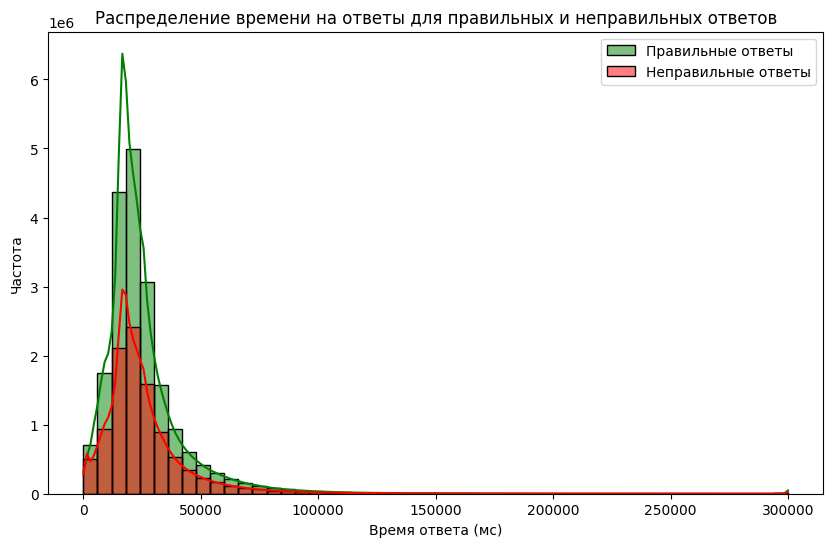

In [113]:
# Анализ распределения времени на ответы для правильных и неправильных ответов
plt.figure(figsize=(10, 6))

# График для правильных ответов
sns.histplot(truncated_train_df[truncated_train_df['answered_correctly'] == 1]['prior_question_elapsed_time'], kde=True, color="green", label="Правильные ответы", bins=50)

# График для неправильных ответов
sns.histplot(truncated_train_df[truncated_train_df['answered_correctly'] == 0]['prior_question_elapsed_time'], kde=True, color="red", label="Неправильные ответы", bins=50)

plt.title('Распределение времени на ответы для правильных и неправильных ответов')
plt.xlabel('Время ответа (мс)')
plt.ylabel('Частота')
plt.legend()
plt.show()


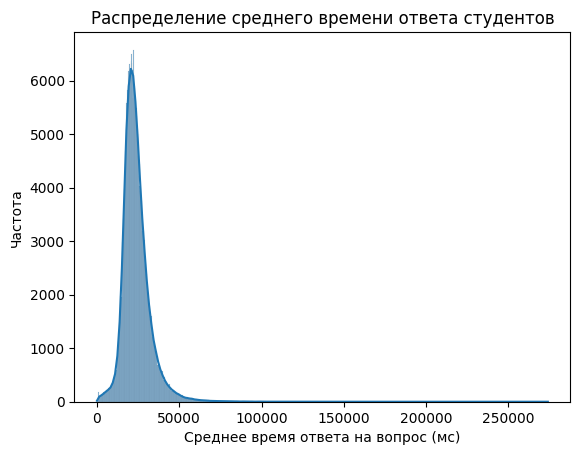

In [ ]:
# Создание графика распределения среденего времени ответа для каждого студента

# Создание датафрейма, со среднем временем ответа для каждого студента
only_questions_df_sorted = only_questions_df.groupby('user_id').agg({'prior_question_elapsed_time': 'mean'})

# Создание графика
sns.histplot(only_questions_df_sorted['prior_question_elapsed_time'], kde=True)
plt.xlabel('Среднее время ответа на вопрос (мс)')
plt.ylabel('Частота')
plt.title('Распределение среднего времени ответа студентов')
plt.show()

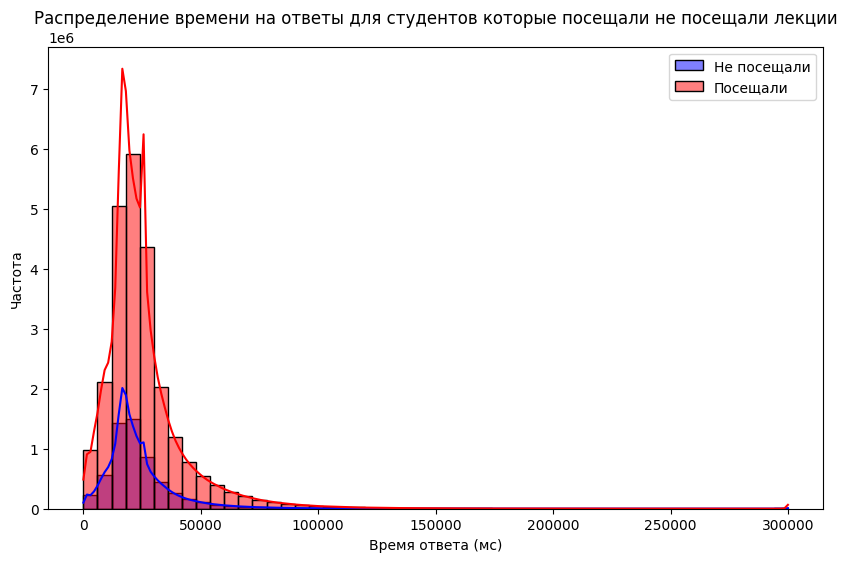

In [ ]:
#Анализ распределения времени на ответы для студентов с разным отношением к посещениям
plt.figure(figsize=(10, 6))

# График для тех, кто посещал лекции
sns.histplot(truncated_train_df[truncated_train_df['attended_lecture'] == False]['prior_question_elapsed_time'], kde=True, color="blue", label="Не посещали", bins=50)

# График для тех, кто не посещал лекции
sns.histplot(truncated_train_df[truncated_train_df['attended_lecture'] == True]['prior_question_elapsed_time'], kde=True, color="red", label="Посещали", bins=50)

plt.title('Распределение времени на ответы для студентов которые посещали не посещали лекции')
plt.xlabel('Время ответа (мс)')
plt.ylabel('Частота')
plt.legend()
plt.show()


C:\Users\1\AppData\Local\Temp\ipykernel_17544\3526019527.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(explanation_correct, palette=['blue', 'red'])


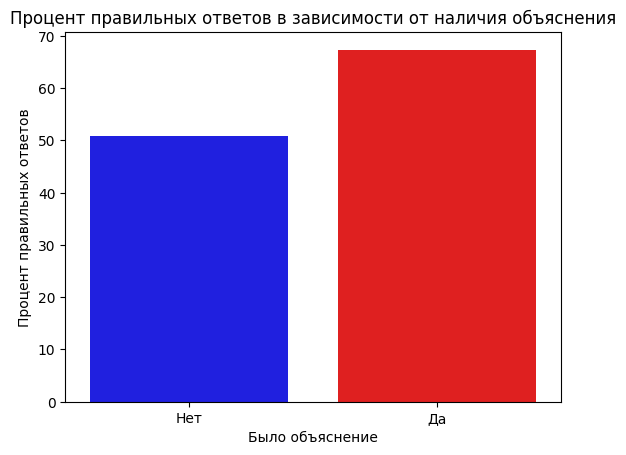

In [119]:
# Графическое представление соотношения ответов к наличию объяснения
# Столбчатая диаграмма
sns.barplot(explanation_correct, palette=['blue', 'red'])
plt.title('Процент правильных ответов в зависимости от наличия объяснения')
plt.xlabel('Было объяснение')
plt.ylabel('Процент правильных ответов')
plt.xticks(ticks=[0, 1], labels=['Нет', 'Да'], rotation=0)
plt.show()


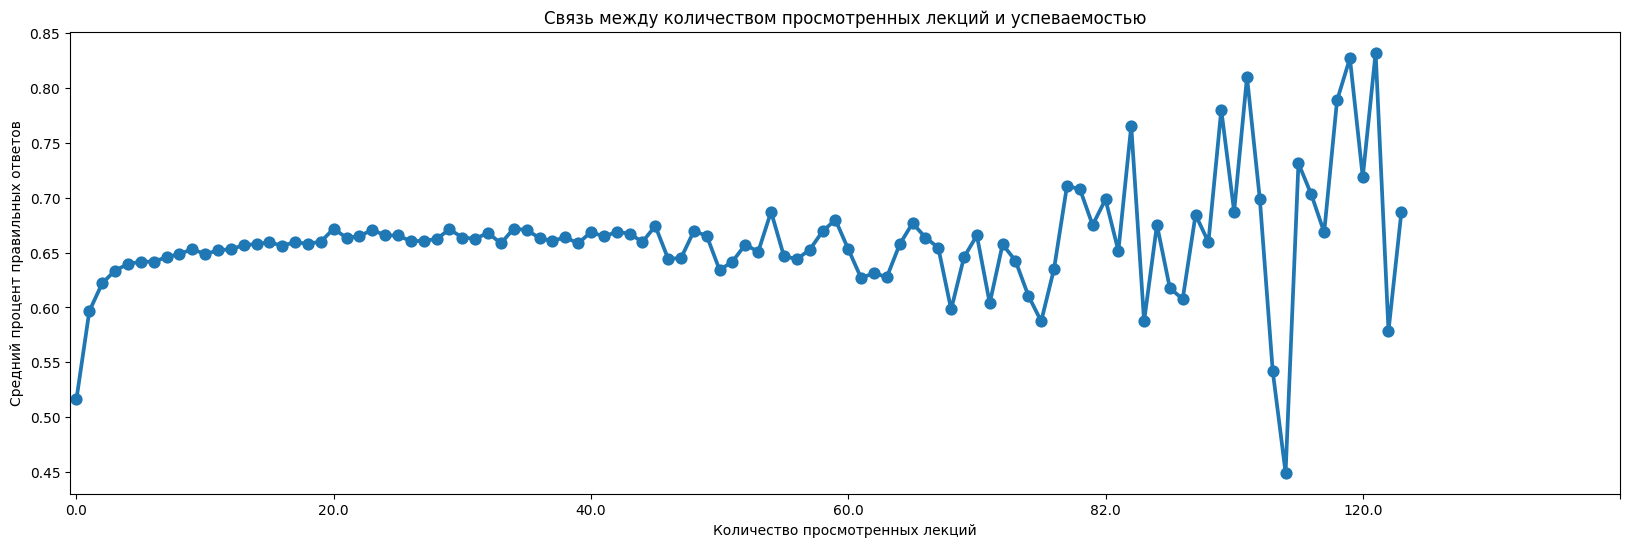

In [ ]:
# Анализ связи между количеством просмотренных лекций и успеваемостью
# Подсчет количества лекций, просмотренных каждым студентом
lectures_count_per_user = truncated_train_df[truncated_train_df['content_type_id'] == 1].groupby('user_id').size().reset_index(name='lectures_watched')

# Подсчет средней правильности ответов для каждого студента
correctness_per_user = truncated_train_df[truncated_train_df['content_type_id'] == 0].groupby('user_id')['answered_correctly'].mean().reset_index(name='avg_correctness')

# Объединение двух таблиц
user_lecture_correctness = pd.merge(correctness_per_user, lectures_count_per_user, on='user_id', how='left')
# Заполняем отсутствующие значения нулями
user_lecture_correctness['lectures_watched'] = user_lecture_correctness['lectures_watched'].fillna(0)

plt.figure(figsize=(20, 6))

sns.pointplot(data=user_lecture_correctness, x='lectures_watched', y='avg_correctness', errorbar=None)
plt.xlabel('Количество просмотренных лекций')
plt.ylabel('Средний процент правильных ответов')
plt.title('Связь между количеством просмотренных лекций и успеваемостью')
plt.xticks(range(0, int(user_lecture_correctness['lectures_watched'].max())+1, 20))
plt.show()